In [1]:
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset
from transformers import AdamW, get_linear_schedule_with_warmup
import os
import pickle

/usr4/cs585bp/phamquan/.local/lib/python3.10/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [2]:
column_names = ["Labels", "Review_Title", "Review_Text"]
amazon_test = pd.read_csv("dataset/test.csv", names = column_names)
amazon_test['Review_Text'] = amazon_test['Review_Text'].str.replace('\\\\n', '\n').replace('""', '"')
amazon_test.head()

,Labels,Review_Title,Review_Text
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [3]:
tokenized_data_path = 'dataset/bert_large_tokenized_test_data.pkl'

print("Loading tokenized data...")
if os.path.exists(tokenized_data_path):
    # Load the tokenized data
    with open(tokenized_data_path, 'rb') as f:
        tokenized_data = pickle.load(f)
    test_inputs = tokenized_data["inputs"]
    test_masks = tokenized_data["masks"]
    print("Loaded tokenized data from disk!")
else:
    raise FileNotFound(f"The file {tokenized_data_path} does not exist. Please tokenize the data first.")

Loading tokenized data...
Loaded tokenized data from disk!


In [4]:
print("Converting dataset to tensors...")
# Convert lists to tensors
test_inputs = torch.cat(test_inputs, dim=0)
test_masks = torch.cat(test_masks, dim=0)

batch_size = 1
# Create the DataLoader
test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
print("Finishing creating test data!")

Converting dataset to tensors...
Finishing creating test data!


In [5]:
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 1024, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-large-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),s
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [6]:
from torch.nn import DataParallel

finetuned_bert_large_classifier = BertClassifier(freeze_bert=False)
finetuned_bert_large_classifier = DataParallel(finetuned_bert_large_classifier)
checkpoint = torch.load('model/finetune_bert_large_uncased.pth')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finetuned_bert_large_classifier.to(device)

DataParallel(
  (module): BertClassifier(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 1024, padding_idx=0)
        (position_embeddings): Embedding(512, 1024)
        (token_type_embeddings): Embedding(2, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=1024, out_features=1024, bias=True)


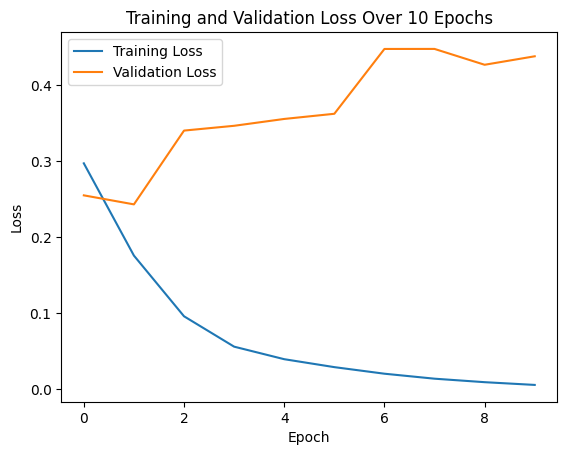

In [7]:
# Finetuned Bert-base-cased Train / Validation plot
# Visualization
import matplotlib.pyplot as plt

train_stats = checkpoint["training_stats"]
num_epoch = len(train_stats['train_loss'])
plt.plot(train_stats['train_loss'], label='Training Loss')
plt.plot(train_stats['validation_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss Over {num_epoch} Epochs')
plt.legend()
plt.show()

In [8]:
# from torch.nn.functional import softmax
# finetuned_bert_large_classifier.load_state_dict(checkpoint['model_state_dict'])
# finetuned_bert_large_classifier.eval()  # Put the model in evaluation mode

# # Tracking variables
# predictions = []
# print("Start Prediction ...")

# # Predict
# for step, batch in enumerate(tqdm(test_dataloader, desc=f"Preidcting")):

#     batch = tuple(t.to(device) for t in batch)
#     b_input_ids, b_input_mask = batch

#     with torch.no_grad():
#         outputs = finetuned_bert_large_classifier(b_input_ids, 
#                                             attention_mask=b_input_mask)

#     logits = outputs
#     logits = logits.detach().cpu()

#     probs = softmax(logits, dim=1).numpy()
#     batch_predictions = np.argmax(probs, axis=1) + 1

#     predictions.extend(batch_predictions)
    
# print("Done Prediction!")

In [9]:
# from sklearn.metrics import accuracy_score, classification_report

# # Now you can compare these predicted_classes with the actual labels to calculate metrics
# # Actual labels
# true_labels = amazon_test['Labels'].values

# # print(len(true_labels))

# # Calculate accuracy
# accuracy = accuracy_score(true_labels, predictions)

# # Detailed classification report
# # print(classification_report(true_labels, predictions))

# print(f"Accuracy: {accuracy*100}%")

The accuracy achieved 90.6% on the prediction test set

In [10]:
from torch.nn.functional import softmax

pretrained_bert_classifier = BertClassifier(freeze_bert=False)
pretrained_bert_classifier.to(device)

# Tracking variables
new_predictions = []
print("Start Prediction ...")

# Predict
for batch in tqdm(test_dataloader, desc="Predicting"):
    
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        outputs = pretrained_bert_classifier(b_input_ids, 
                                            attention_mask=b_input_mask)
    
    logits = outputs
    logits = logits.detach().cpu()
    
    probs = softmax(logits, dim=1).numpy()
    batch_predictions = np.argmax(probs, axis=1) + 1
    
    new_predictions.extend(batch_predictions)

print("Done Prediction!")

Start Prediction ...


Predicting: 100%|██████████| 400000/400000 [4:21:04<00:00, 25.54it/s]  

Done Prediction!


In [13]:
from sklearn.metrics import accuracy_score, classification_report
true_labels = amazon_test['Labels'].values

# Calculate accuracy
pretrained_accuracy = accuracy_score(true_labels, new_predictions)


# Detailed classification report

print(f"Accuracy: {pretrained_accuracy*100}%")

Accuracy: 38.81%
